In [1]:
%matplotlib inline

import sys
import random
import pickle
import chromadb
import numpy as np
from pprint import pprint
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import networkx as nx
import json
from pyvis.network import Network
from sklearn.metrics import ndcg_score

sys.path.append("../")
from utils.metadata_graph import *
from utils.vector_search_utils import *
from utils.parse_arxiv import *
from compute_metrics import batch_compute_percent_include, compute_percent_include

chroma_client = chromadb.PersistentClient(path="../data/chroma_dbs/")
chroma_client.list_collections()

/data/zyang/miniconda3/envs/pt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Collection(name=cnn_headline),
 Collection(name=arxiv_title),
 Collection(name=arxiv_abstract),
 Collection(name=wiki_plot),
 Collection(name=wiki_plot_summary),
 Collection(name=cnn_article)]

In [2]:
test_coll = chroma_client.get_collection("arxiv_title")
gt_coll = chroma_client.get_collection("arxiv_abstract")

# read workload csv
workload_csv = "../data/arxiv/arxiv_workloads/pn1000_n1.csv"
workload_df = pd.read_csv(workload_csv)

text_queries = workload_df["query"].tolist()

In [7]:
# k = 10
# test_k = k 

# gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
# test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

In [8]:
def exp(gt_coll, test_coll, k, kps, text_queries, gt_res, test_res):
    mean_recalls = []
    gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
    for kp in kps:
        # increase test k
        test_k = int( (1 + kp) * k)
        test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)
        recalls = batch_compute_percent_include(gt_res, test_res)
        mean_recalls.append(np.mean(recalls))
    return mean_recalls

In [ ]:
# make plot mean-recalls vs. % of extra k (0 to 100% increase)
ks = [5, 10, 50, 100, 500]
kps = np.arange(0, 1.2, 0.2)

mean_recall_dict = {}
for k in ks:
    mean_recalls = exp(gt_coll, test_coll, k, kps, text_queries, gt_res, test_res)
    mean_recall_dict[k] = mean_recalls

In [ ]:
# plot all
fig, ax = plt.subplots(figsize=(5, 3))
for k in ks:
    ax.plot(kps, mean_recall_dict[k], label=f"k={k}")
    ax.set_xlabel("Extra k (%)")
    ax.set_ylabel("Mean Recall")
# ax.set_title("Mean recall vs. percentage of extra k")
ax.legend()
plt.show()

# Exp

In [9]:
 # load pickle
g_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))

pprint(g_data.data_dict['id_1009.5145'])
print()
print(g_data.keyword_dict['author:YonghuiLi'])

{'author:RaymondH.Y.Louie',
 'author:YonghuiLi',
 'author:andBrankaVucetic',
 'category:cs.IT',
 'category:math.IT',
 'journal:IEEE Transactions on Vehicular Technology, 2010',
 'year:2016'}

{'id_2106.02811', 'id_1009.5145'}


## GT Distribution in 2*k

In [17]:
def find_elements_in_list(elements, l):
    # find elements in list, return a list of index of l
    idxs = []
    for e in elements:
        if e not in l: continue
        idx = l.index(e)
        idxs.append(idx)
    return idxs

# test
l = [1, 2, 3, 4, 5]
elements = [3, 4, 10]
print(find_elements_in_list(elements, l))

[2, 3]


In [38]:
k = 10
test_k = k * 2

gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


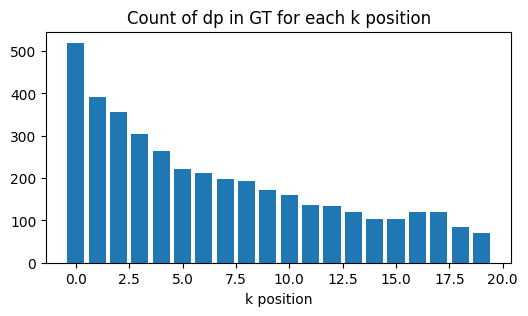

In [79]:
# For each res, For each posistion of k, count the number of dp that is in GT

kpos_count_dict = {}

for res_index, one_t_res in enumerate(test_res):
    one_gt_res = gt_res[res_index]
    idxs = find_elements_in_list(one_gt_res, one_t_res)
    for i in idxs:
        if i not in kpos_count_dict: kpos_count_dict[i] = 0
        kpos_count_dict[i] += 1

# plot kpos_count_dict
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(kpos_count_dict.keys(), np.array(list(kpos_count_dict.values()))/1)
ax.set_xlabel("k position")
# ax.set_ylabel("Count")
ax.set_title("Count of dp in GT for each k position")
plt.show()

In [48]:
def construct_metagraph_from_ids(id_list, g_data):
    mg = MetadataGraph()
    metadata_sets = []
    for id in id_list:
        metadata_sets.append(g_data.data_dict[id])
    mg.build_from_metadata_set_list(metadata_sets)
    return mg

def compute_avg_degree_centrality_for_ids(id_list, mg, g_data):
    dc = nx.degree_centrality(mg.G)
    # sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))
    dp_meta_score = {}
    for dp_id in id_list:
        metadata = g_data.data_dict[dp_id]
        # compute metadata score (avg degree centrality of metadata)
        dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])
    return dp_meta_score

In [67]:
query_idx = 10
tmp_sample = test_res[query_idx]
tmp_gt_sample = gt_res[query_idx]

# construct metagraph
mg = construct_metagraph_from_ids(tmp_sample, g_data)
dp_meta_score = compute_avg_degree_centrality_for_ids(tmp_sample, mg, g_data)

find_elements_in_list(tmp_gt_sample, tmp_sample)

[0, 1]

In [10]:
k = 10
test_k = k * 2

gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


In [ ]:
query_idx = 10
tmp_sample = test_res[query_idx]

mg = construct_metagraph_from_ids(tmp_sample, g_data)

In [ ]:
dc = nx.degree_centrality(mg.G)

# sort by degree centrality
sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))
# sorted_dc

In [ ]:
dp_meta_score = {}
for dp_id in tmp_sample:
    # print(dp)
    metadata = g_data.data_dict[dp_id]
    # compute metadata score (avg degree centrality of metadata)
    dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])

In [ ]:
print("precent include")
print("before  :", compute_percent_include(gt_res[0], tmp_sample[:10]))

# re-rank by metadata score
sorted_dp_meta_score = dict(sorted(dp_meta_score.items(), key=lambda x: x[1], reverse=True))
re_ranked_dps = list(sorted_dp_meta_score.keys())

print("re-rank :", compute_percent_include(gt_res[query_idx], re_ranked_dps[:10]))

print("upper-bound:", compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))

# re-rank workloads

In [68]:
k = 10
test_k = k * 2

gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


## Degree_centrality

In [69]:
befores = []
afters = []
upper_bounds = []

for query_idx in tqdm(range(len(text_queries))):
    tmp_sample = test_res[query_idx]
    mg = construct_metagraph_from_ids(tmp_sample, g_data)
    
    dc = nx.degree_centrality(mg.G)
    # sort by degree centrality
    sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))

    dp_meta_score = {}
    for i, dp_id in enumerate(tmp_sample):
        metadata = g_data.data_dict[dp_id]
        # compute metadata score (avg degree centrality of metadata)
        dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(tmp_sample))

    # re-rank by metadata score
    sorted_dp_meta_score = dict(sorted(dp_meta_score.items(), key=lambda x: x[1], reverse=True))
    re_ranked_dps = list(sorted_dp_meta_score.keys())

    # befores.append(ndcg_score([gt_res[query_idx]], [tmp_sample[:k]]))
    # afters.append(ndcg_score([gt_res[query_idx]], [re_ranked_dps[:k]]))
    befores.append(compute_percent_include(gt_res[query_idx], tmp_sample[:k]))
    afters.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:k]))
    upper_bounds.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))
    # print("precent include")
    # print("before  :", compute_percent_include(gt_res[0], tmp_sample[:10]))
    # print("re-rank :", compute_percent_include(gt_res[query_idx], re_ranked_dps[:10]))
    # print("upper-bound:", compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))

100%|██████████| 1000/1000 [00:11<00:00, 88.65it/s]


In [70]:
print("before  :", np.mean(befores))
print("re-rank :", np.mean(afters))
print("upper-bound:", np.mean(upper_bounds))

before  : 0.2833
re-rank : 0.2825
upper-bound: 0.3987


## closeness_centrality

In [71]:
befores = []
afters = []
upper_bounds = []

for query_idx in tqdm(range(len(text_queries))):
    tmp_sample = test_res[query_idx]
    mg = construct_metagraph_from_ids(tmp_sample, g_data)
    
    dc = nx.closeness_centrality(mg.G)
    # sort by degree centrality
    sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))

    dp_meta_score = {}
    for i, dp_id in enumerate(tmp_sample):
        metadata = g_data.data_dict[dp_id]
        # compute metadata score (avg degree centrality of metadata)
        dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(tmp_sample))

    # re-rank by metadata score
    sorted_dp_meta_score = dict(sorted(dp_meta_score.items(), key=lambda x: x[1], reverse=True))
    re_ranked_dps = list(sorted_dp_meta_score.keys())

    # befores.append(ndcg_score([gt_res[query_idx]], [tmp_sample[:k]]))
    # afters.append(ndcg_score([gt_res[query_idx]], [re_ranked_dps[:k]]))
    befores.append(compute_percent_include(gt_res[query_idx], tmp_sample[:k]))
    afters.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:k]))
    upper_bounds.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))
    # print("precent include")
    # print("before  :", compute_percent_include(gt_res[0], tmp_sample[:10]))
    # print("re-rank :", compute_percent_include(gt_res[query_idx], re_ranked_dps[:10]))
    # print("upper-bound:", compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))

100%|██████████| 1000/1000 [08:00<00:00,  2.08it/s]


In [72]:
print("before  :", np.mean(befores))
print("re-rank :", np.mean(afters))
print("upper-bound:", np.mean(upper_bounds))

before  : 0.2833
re-rank : 0.2849
upper-bound: 0.3987


## laplacian_centrality

In [73]:
befores = []
afters = []
upper_bounds = []

for query_idx in tqdm(range(len(text_queries))):
    tmp_sample = test_res[query_idx]
    mg = construct_metagraph_from_ids(tmp_sample, g_data)
    
    dc = nx.laplacian_centrality(mg.G)
    # sort by degree centrality
    sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))

    dp_meta_score = {}
    for i, dp_id in enumerate(tmp_sample):
        metadata = g_data.data_dict[dp_id]
        # compute metadata score (avg degree centrality of metadata)
        dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(tmp_sample))

    # re-rank by metadata score
    sorted_dp_meta_score = dict(sorted(dp_meta_score.items(), key=lambda x: x[1], reverse=True))
    re_ranked_dps = list(sorted_dp_meta_score.keys())

    # befores.append(ndcg_score([gt_res[query_idx]], [tmp_sample[:k]]))
    # afters.append(ndcg_score([gt_res[query_idx]], [re_ranked_dps[:k]]))
    befores.append(compute_percent_include(gt_res[query_idx], tmp_sample[:k]))
    afters.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:k]))
    upper_bounds.append(compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))
    # print("precent include")
    # print("before  :", compute_percent_include(gt_res[0], tmp_sample[:10]))
    # print("re-rank :", compute_percent_include(gt_res[query_idx], re_ranked_dps[:10]))
    # print("upper-bound:", compute_percent_include(gt_res[query_idx], re_ranked_dps[:]))

100%|██████████| 1000/1000 [54:09<00:00,  3.25s/it]   


In [74]:
print("before  :", np.mean(befores))
print("re-rank :", np.mean(afters))
print("upper-bound:", np.mean(upper_bounds))

before  : 0.2833
re-rank : 0.2745
upper-bound: 0.3987


# metadata analysis on GT

In [77]:
sample_gt = gt_res[0]

mg = construct_metagraph_from_ids(sample_gt, g_data)
dc = nx.closeness_centrality(mg.G)

In [20]:
# dc

# beyond topk GT analysis

In [3]:
# Get a workload results
test_coll = chroma_client.get_collection("arxiv_title")
gt_coll = chroma_client.get_collection("arxiv_abstract")
workload_csv = "../data/arxiv/arxiv_workloads/pn1000_n1.csv"
workload_df = pd.read_csv(workload_csv)
text_queries = workload_df["query"].tolist()

 # load pickle
g_data = pickle.load(open('../data/arxiv/graph.pickle', 'rb'))

k = 10
test_k = k * 5

gt_res = vector_search(coll=gt_coll, text_queries=text_queries, k=k, batch_size=100)
test_res = vector_search(coll=test_coll, text_queries=text_queries, k=test_k, batch_size=100)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


In [4]:
'''
GT positions

For gt in gt_res, find the position of gt in test_res, return a list of positions matches the shape of gt_res
'''

def find_gt_positions(one_gt_res, one_test_res):
    gt_positions = []
    for gt in one_gt_res:
        if gt not in one_test_res:
            gt_positions.append(-1)
        else:
            gt_positions.append(one_test_res.index(gt))
    return gt_positions

def find_gt_positions_for_all(gt_res, test_res):
    gt_positions = []
    for i in range(len(gt_res)):
        gt_positions.append(find_gt_positions(gt_res[i], test_res[i]))
    return gt_positions

In [5]:
gt_pos_in_test = find_gt_positions_for_all(gt_res, test_res)
# gt_pos_in_test

 10%|█████████████████▎                                                                                                                                                             | 99/1000 [00:00<00:08, 105.73it/s]


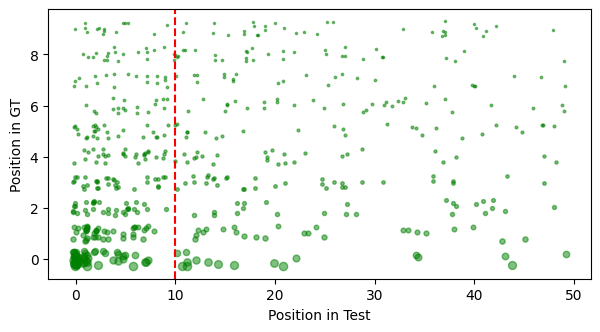

In [6]:
# plot gt pos (index in l) vs. test pos (val, -1 means not found)
counter = 0

fig, ax = plt.subplots(figsize=(7, 3.5))
for one_gt_pos in tqdm(gt_pos_in_test):
    counter += 1
    for i, pos in enumerate(one_gt_pos):
        if pos == -1: continue
        # randomly wiggly the i for better visualization
        i = i + random.uniform(-0.3, 0.3)
        pos = pos + random.uniform(-0.3, 0.3)
        ax.scatter(pos, i, s=(1/(i+1))*100, marker='.', color='green', alpha=0.5)
    if counter==100: break

# add vertical line at k
ax.axvline(x=k, color='red', linestyle='--')
    
# add horizontal line at k
# ax.axhline(y=k, color='red', linestyle='--')

ax.set_ylabel("Position in GT")
ax.set_xlabel("Position in Test")
# ax.set_title("GT Position in Test")
plt.savefig("gt_pos_in_test.png")
plt.show()

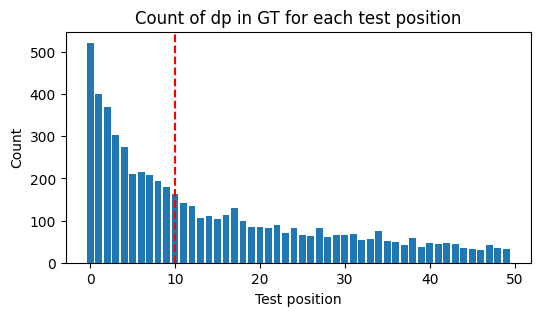

In [8]:
# make a bar plot count number of dp in GT for each test position

test_pos_numGT_dict = {}
for sample_res in gt_pos_in_test:
    for i, pos in enumerate(sample_res):
        if pos not in test_pos_numGT_dict and pos != -1:
            test_pos_numGT_dict[pos] = 1
        if pos != -1: test_pos_numGT_dict[pos] += 1

# plot test_pos_numGT_dict
fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(test_pos_numGT_dict.keys(), np.array(list(test_pos_numGT_dict.values()))/1)
ax.set_xlabel("Test position")
ax.set_ylabel("Count")
ax.set_title("Count of dp in GT for each test position")
# add vertical line at k
ax.axvline(x=k, color='red', linestyle='--')
plt.savefig("gt_study_plot/test_pos_numGT.pdf")

plt.show()

In [9]:
# centrality for GT outside of top k
def construct_metagraph_from_ids(id_list, g_data):
    mg = MetadataGraph()
    metadata_sets = []
    for id in id_list:
        metadata_sets.append(g_data.data_dict[id])
    mg.build_from_metadata_set_list(metadata_sets)
    return mg

def compute_avg_degree_centrality_for_ids(id_list, mg, g_data):
    dc = nx.degree_centrality(mg.G)
    # sorted_dc = dict(sorted(dc.items(), key=lambda x: x[1], reverse=True))
    dp_meta_score = {}
    for dp_id in id_list:
        metadata = g_data.data_dict[dp_id]
        # compute metadata score (avg degree centrality of metadata)
        dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])
    return dp_meta_score

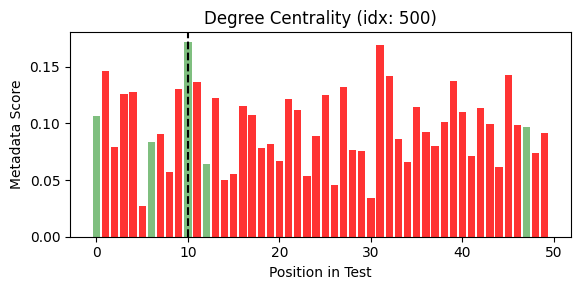

In [10]:
sample_idx = 500

# print(gt_res[sample_idx])
# print(test_res[sample_idx])
# print(gt_pos_in_test[sample_idx])

# create metadata graph, get degree centrality
mg = construct_metagraph_from_ids(test_res[sample_idx], g_data)
dc = nx.degree_centrality(mg.G)

# for dp in test_res[sample_idx] and in GT, compute metadata score
dp_meta_score = {}
for i, dp_id in enumerate(test_res[sample_idx]):
    metadata = g_data.data_dict[dp_id]
    dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])

'''
plot dp_meta_score bar plot

x-axis: dp position in test_res
y-axis: metadata score
color: green for GT, red for not in GT
'''

fig, ax = plt.subplots(figsize=(6, 3))
for i, dp_id in enumerate(test_res[sample_idx]):
    if dp_id in gt_res[sample_idx]:
        ax.bar(i, dp_meta_score[dp_id], color='green', alpha=0.5, label='GT')
    else:
        ax.bar(i, dp_meta_score[dp_id], color='red', alpha=0.8)
ax.set_xlabel("Position in Test")
ax.set_ylabel("Metadata Score")

# add vertical line at k
ax.axvline(x=k, color='black', linestyle='--')
ax.set_title("Degree Centrality (idx: %d)" % sample_idx)
plt.tight_layout()
plt.show()

## Degree_centrality

In [56]:
def plot_degree_centrality_for_idx(sample_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=None):
    mg = construct_metagraph_from_ids(test_res[sample_idx], g_data)
    dc = nx.degree_centrality(mg.G)

    # for dp in test_res[sample_idx] and in GT, compute metadata score
    dp_meta_score = {}
    for i, dp_id in enumerate(test_res[sample_idx]):
        metadata = g_data.data_dict[dp_id]
        if account_for_position:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(test_res[sample_idx]))
        else:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.5, 2.5))
        
    for i, dp_id in enumerate(test_res[sample_idx]):
        if dp_id in gt_res[sample_idx]:
            ax.bar(i, dp_meta_score[dp_id], color='green', alpha=0.9, label='GT')
            ax.axhline(dp_meta_score[dp_id], color='green', linestyle='--', alpha=0.35, linewidth=0.7)
        else:
            ax.bar(i, dp_meta_score[dp_id], color='red', alpha=0.65)
    ax.set_xlabel("Position in Test")
    ax.set_ylabel("Metadata Score")
    # add vertical line at k
    ax.axvline(x=k, color='black', linestyle='--', linewidth=2)
    ax.set_title("Degree Centrality (idx: %d) \n AccountPosition: %s" % (sample_idx, account_for_position))
    # set x-limit to k
    ax.set_xlim([0, len(test_res[sample_idx])])
    # plt.tight_layout()
    # plt.show()
    return ax

In [ ]:
# depend on number of random idx, make subplots, in 2 columns: accout for position and not

number_of_plots = 50
random_idx_list = [random.randint(0, len(test_res)) for _ in range(number_of_plots)]

fig, axs = plt.subplots(number_of_plots, 2, figsize=(13, 3*number_of_plots))

for i, random_idx in enumerate(random_idx_list):
    plot_degree_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=axs[i][0])
    plot_degree_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=True, ax=axs[i][1])
plt.tight_layout()
plt.savefig("gt_study_plot/degree_centrality.pdf")
plt.show()

## closeness_centrality

In [ ]:
def plot_closeness_centrality_for_idx(sample_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=None):
    mg = construct_metagraph_from_ids(test_res[sample_idx], g_data)
    dc = nx.closeness_centrality(mg.G)

    # for dp in test_res[sample_idx] and in GT, compute metadata score
    dp_meta_score = {}
    for i, dp_id in enumerate(test_res[sample_idx]):
        metadata = g_data.data_dict[dp_id]
        if account_for_position:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(test_res[sample_idx]))
        else:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.5, 2.5))
        
    for i, dp_id in enumerate(test_res[sample_idx]):
        if dp_id in gt_res[sample_idx]:
            ax.bar(i, dp_meta_score[dp_id], color='green', alpha=0.9, label='GT')
            ax.axhline(dp_meta_score[dp_id], color='green', linestyle='--', alpha=0.35, linewidth=0.7)
        else:
            ax.bar(i, dp_meta_score[dp_id], color='red', alpha=0.65)
    ax.set_xlabel("Position in Test")
    ax.set_ylabel("Metadata Score")
    # add vertical line at k
    ax.axvline(x=k, color='black', linestyle='--', linewidth=2)
    ax.set_title("Closeness Centrality (idx: %d) \n AccountPosition: %s" % (sample_idx, account_for_position))
    # set x-limit to k
    ax.set_xlim([0, len(test_res[sample_idx])])
    # plt.tight_layout()
    # plt.show()
    return ax

In [ ]:
number_of_plots = len(random_idx_list)

fig, axs = plt.subplots(number_of_plots, 2, figsize=(13, 3*number_of_plots))

for i, random_idx in enumerate(random_idx_list):
    plot_closeness_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=axs[i][0])
    plot_closeness_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=True, ax=axs[i][1])
plt.tight_layout()
plt.savefig("gt_study_plot/closeness_centrality.pdf")
plt.show()

## laplacian_centrality

In [ ]:
def plot_laplacian_centrality_for_idx(sample_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=None):
    mg = construct_metagraph_from_ids(test_res[sample_idx], g_data)
    dc = nx.laplacian_centrality(mg.G)

    # for dp in test_res[sample_idx] and in GT, compute metadata score
    dp_meta_score = {}
    for i, dp_id in enumerate(test_res[sample_idx]):
        metadata = g_data.data_dict[dp_id]
        if account_for_position:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata]) * (1 - i/len(test_res[sample_idx]))
        else:
            dp_meta_score[dp_id] = np.mean([dc[md] for md in metadata])
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.5, 2.5))
        
    for i, dp_id in enumerate(test_res[sample_idx]):
        if dp_id in gt_res[sample_idx]:
            ax.bar(i, dp_meta_score[dp_id], color='green', alpha=0.9, label='GT')
            ax.axhline(dp_meta_score[dp_id], color='green', linestyle='--', alpha=0.35, linewidth=0.7)
        else:
            ax.bar(i, dp_meta_score[dp_id], color='red', alpha=0.65)
    ax.set_xlabel("Position in Test")
    ax.set_ylabel("Metadata Score")
    # add vertical line at k
    ax.axvline(x=k, color='black', linestyle='--', linewidth=2)
    ax.set_title("Laplacian Centrality (idx: %d) \n AccountPosition: %s" % (sample_idx, account_for_position))
    # set x-limit to k
    ax.set_xlim([0, len(test_res[sample_idx])])
    # plt.tight_layout()
    # plt.show()
    return ax

In [ ]:
number_of_plots = len(random_idx_list)

fig, axs = plt.subplots(number_of_plots, 2, figsize=(13, 3*number_of_plots))

for i, random_idx in enumerate(random_idx_list):
    plot_laplacian_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=False, ax=axs[i][0])
    plot_laplacian_centrality_for_idx(random_idx, test_res, gt_res, g_data, k, account_for_position=True, ax=axs[i][1])
plt.tight_layout()
plt.savefig("gt_study_plot/laplacian_centrality.pdf")
plt.show()